This notebook is a bit long with several parts

1. Define callable functions and create series of circuits with qubits
   in range from n to m and k copies of each
2. run the circuits in IBM simulators (be prepared to wait with large values)
   and failed runs. Easier to wait until all simulations have run successfully
   and retrieve stored results.
3. Calculate the success probabilities and make graphs


In [31]:
import matplotlib.pyplot as plt
import math
%matplotlib inline
import numpy as np
import inspect
import scipy

from math import pi

from scipy.special import factorial as fac
from scipy.special import comb as comb

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.quantum_info.operators import Operator # operators
from qiskit.circuit import Gate # Custom gate
from qiskit.tools.visualization import circuit_drawer, plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit.quantum_info import state_fidelity
from qiskit import Aer, transpile
## Logging to IBMQ ##
from qiskit import IBMQ
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor

from qiskit.providers.aer.noise import pauli_error

In [58]:
# Function to calculate the success probability from simulation counts
def successProb(counts):

    lista = []
    tmp = []
    zeros = []
    ones = []


    for i in range(int(len(counts)/k)):
        zero = []
        one = []
        for j in range(k):
            tmp0 = 0
            tmp1 = 0
            for l in counts[j+i*k].items():
                if( l[0].count('0') > l[0].count('1')) or (l[0].count('0') == l[0].count('1')):
                    if(l[0].count('0') == l[0].count('1')):
                        tmp0 = tmp0 + l[1]/2
                    else:
                        tmp0 = tmp0 + l[1]
                else:
                    tmp1 = tmp1 + l[1]
            zero.append(tmp0)
            one.append(tmp1)
            tmp.append(counts[j+i*k])
        lista.append(tmp)
        zeros.append(sum(zero)/(k*shots))
        ones.append(sum(one)/(k*shots))
    return zeros

In [32]:
# Function to calculate the prediction for success probability

def successProbabilityPrediction(n,L):
    i = int((n+1)/2)
    Lambda = (1 + np.sin(2*L))/2
    summa = 0
    while(i <= n):
        bin1 = comb(n,i,exact=True)
        
        power1 = Lambda**i*(1-Lambda)**(n-i)
        power2 = Lambda**(n-i)*(1-Lambda)**i


        tmp = (bin1*(power1-power2)) #could be sum, but for debugging this is better
        summa = summa + tmp

        i += 1
    p = 1/2*(1+summa)
    return p

In [2]:
## Preparing 3 seperate circuits with n qubits##

#### SigmaXY ####
def SigmaXY(n, theta, Lambda):
    # Unitary Operator
    L = Lambda
    sub_q1 = QuantumRegister(2)
    sub_XY = QuantumCircuit(sub_q1, name='$e^{\sigma_x \otimes \sigma_y}$')


    sigmaXY = Operator([[math.cos (L)  , 0           , 0, math.sin(L)],
                        [0, math.cos(L), -math.sin(L), 0],
                        [0, math.sin(L),  math.cos(L), 0],
                        [-math.sin(L), 0, 0, math.cos(L)]])

    sub_XY.unitary(sigmaXY, [sub_q1[1], sub_q1[0]], label='SigmaXY')
    #sub_XY.barrier()
    #sub_XY.z(sub_q1[1])  Just a reminder


    sub_inst_XY = sub_XY.to_instruction()
    
    # Circuit
    qr_XY = QuantumRegister(n, name='q_XY')
    cr_XY = ClassicalRegister(n-1, name='c_XY')
    circ_XY = QuantumCircuit(qr_XY,cr_XY)
    circ_XY.h(qr_XY) 
    circ_XY.barrier()
    for i in range(1,n):
        circ_XY.append(sub_XY, [0,i])

    circ_XY.barrier()
    
    for i in range(1,n):
        circ_XY.measure(i,i-1)
    return circ_XY
#### SigmaXZ ####
def SigmaXZ(n, theta, Lamda):
    # Unitary Operator
    L = Lambda

    sub_q2 = QuantumRegister(2)
    sub_XZ = QuantumCircuit(sub_q2, name='$e^{\sigma_x \otimes \sigma_z}$')


    sigmaXZ = Operator([[math.cos(L),0,math.sin(L)*1j,0],
                        [0,math.cos(L),0,-math.sin(L)*1j],
                        [math.sin(L)*1j,0,math.cos(L),0],
                        [0,-math.sin(L)*1j,0,math.cos(L)]])

    sub_XZ.unitary(sigmaXZ,[sub_q2[1], sub_q2[0]],label="SigmaXZ")
    #sub_XZ.barrier()
    #sub_XZ.x(1)  Just a reminder
    sub_inst_XZ = sub_XZ.to_instruction()

    # Circuit
    qr_XZ = QuantumRegister(n, name='q_XZ')
    cr_XZ = ClassicalRegister(n-1, name='c_XZ')
    circ_XZ = QuantumCircuit(qr_XZ, cr_XZ)

    circ_XZ.h(0) # Hadamard on first and Rx rotation on others
    
    for i in range(1,n):
        circ_XZ.rx(theta, i)
    circ_XZ.barrier()

    for i in range(1,n):
        circ_XZ.append(sub_XZ, [0,i])

    circ_XZ.barrier()

    for i in range(1,n):
        circ_XZ.h(i)

    for i in range(1,n):
        circ_XZ.measure(i,i-1)
    return circ_XZ
#### SigmaXX ####
def SigmaXX(n, theta, Lambda):
    # Unitary Operator    
    L = Lambda
    
    sub_q3 = QuantumRegister(2, name='q3')
    sub_XX = QuantumCircuit(sub_q3, name='$e^{\sigma_x \otimes \sigma_x}$')


    sigmaXX = Operator([[math.cos (L), 0 , 0, math.sin(L)*1j],
                        [0, math.cos(L), math.sin(L)*1j, 0],
                        [0, math.sin(L)*1j, math.cos(L), 0],
                        [math.sin(L)*1j, 0, 0, math.cos(L)]])

    sub_XX.unitary(sigmaXX, [sub_q3[1], sub_q3[0]],label='SigmaXX')
    #sub_XX.barrier()
    #sub_XX.y(1) Just a reminder

    sub_inst_XX = sub_XX.to_instruction()
    
    # Circuit    
    qr_XX = QuantumRegister(n, name='q_XX')
    cr_XX = ClassicalRegister(n-1, name='c_XX')
    circ_XX = QuantumCircuit(qr_XX, cr_XX)

    circ_XX.h(0) # Hadamard on the first qubit
    circ_XX.barrier()
## Operations  on XX ##
    for i in range(1,n):
        circ_XX.append(sub_XX, [0,i])

    circ_XX.barrier()

    for i in range(1,n):
        circ_XX.h(i)
        circ_XX.sdg(i)

    for i in range(1,n):
        circ_XX.measure(i,i-1)
    return circ_XX

In [7]:
# create a series of circuits starting from n to m qubits, with k copies of each number.
n = 2
m = 23
k = 2 
theta = math.pi/4
Lambda = math.pi/32

# Sets of circuits, easier to have them separate from this phase. As they can't be run
# at the same time due to limited time provided by the IBM simulator.
circ_0 = [] #lambda = 0
circ_4 = [] #lambda = pi/4
circ_8 = []
circ_16 = []
circ_32 = [] #lambda = pi/32

# A relic from testing other values
#circ_XZ = SigmaXZ(n,theta,Lambda)
#circ_XX = SigmaXX(n,theta,Lambda)

In [76]:
# This could be written in a more sane manner, but this works just fine.
# Change the value of Lambda and circ_<number> and run until all is covered

Lambda = 0 #pi/4
for j in range(n,m):
    subcirc_XY = []
    for i in range(k):
        subcirc_XY.append(SigmaXY(j,theta,Lambda))
    circ_0.append(subcirc_XY)

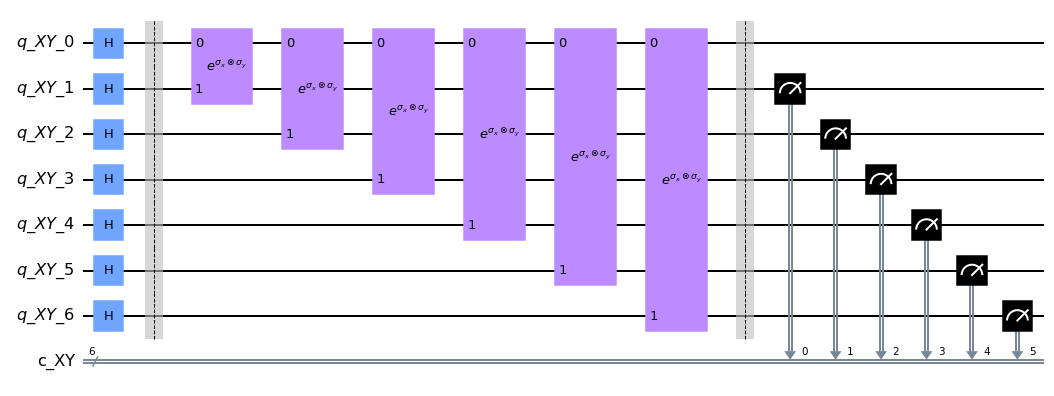

In [13]:
circ_16[5][0].draw()

In [14]:
# Define Bit-flip-noise

# Error probabilities
p_reset = 0.05
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'measure', 'u2', 'reset', 'cx']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [133]:
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-05-29 15:41:43,718: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [16]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_qasm_simulator')

## provider.backends()

In [77]:
## circuits to one-dimensional lists and transpile them, this could be cleaner. But it works as intended.

circs_0 = []
circs_4 = []
circs_8 = []
circs_16 = []
circs_32 = []
for i in range(len(circ_0)):
    for j in circ_0[i]:
        circs_0.append(j)
for i in range(len(circ_4)):
    for j in circ_4[i]:
        circs_4.append(j)
for i in range(len(circ_8)):
    for j in circ_8[i]:
        circs_8.append(j)
for i in range(len(circ_16)):
    for j in circ_16[i]:
        circs_16.append(j)
for i in range(len(circ_32)):
    for j in circ_32[i]:
        circs_32.append(j)
circs_0 = transpile(circs_0, backend=backend)
circs_4 = transpile(circs_4, backend=backend)        
circs_8 = transpile(circs_8, backend=backend)        
circs_16 = transpile(circs_16, backend=backend)        
circs_32 = transpile(circs_32, backend=backend)        

In [65]:
# Each with noise will take time to finish with large numbers. Patience required, check progress at
# https://quantum-computing.ibm.com. Remember that there's a upper limit on how many can be
# ran at once. With n=2,m=23,k=2 it took over 2 hours for each vs seconds with ideal simulations.
shots = 8192
job_manager = IBMQJobManager()
noisy0 = job_manager.run(circs_0, noise_model = noise_bit_flip,
                       backend=backend,name='Lüders\'s instrument lambda=0',
                       shots=shots)

In [75]:
# Same but no noise
job_manager = IBMQJobManager()
ideal0 = job_manager.run(circs_0,
                       backend=backend,name='Ideal Lüders\'s instrument lambda=0',
                       shots=shots)

In [21]:
shots = 8192
job_manager = IBMQJobManager()
noisy4 = job_manager.run(circs_4, noise_model = noise_bit_flip,
                       backend=backend,name='Lüders\'s instrument pi/4',
                       shots=shots)

In [22]:
# Same but no noise
job_manager = IBMQJobManager()
ideal4 = job_manager.run(circs_4,
                       backend=backend,name='Ideal Lüders\'s instrument pi/4',
                       shots=shots)

In [66]:
shots = 8192
job_manager = IBMQJobManager()
noisy8 = job_manager.run(circs_8, noise_model = noise_bit_flip,
                       backend=backend,name='Lüders\'s instrument pi/8',
                       shots=shots)

In [23]:
# Same but no noise
job_manager = IBMQJobManager()
ideal8 = job_manager.run(circs_8,
                       backend=backend,name='Ideal Lüders\'s instrument pi/8',
                       shots=shots)

In [41]:
shots = 8192
job_manager = IBMQJobManager()
noisy16 = job_manager.run(circs_16, noise_model = noise_bit_flip,
                       backend=backend,name='Lüders\'s instrument pi/16',
                       shots=shots)

In [24]:
# Same but no noise
job_manager = IBMQJobManager()
ideal16 = job_manager.run(circs_16,
                       backend=backend,name='Ideal Lüders\'s instrument pi/16',
                       shots=shots)

In [42]:
shots = 8192
job_manager = IBMQJobManager()
noisy32 = job_manager.run(circs_32, noise_model = noise_bit_flip,
                       backend=backend,name='Lüders\'s instrument pi/32',
                       shots=shots)

In [25]:
# Same but no noise
job_manager = IBMQJobManager()
ideal32 = job_manager.run(circs_32,
                       backend=backend,name='Ideal Lüders\'s instrument pi/32',
                       shots=shots)

In [111]:
# Resulting counts
# OR return saved jobs --> next cell. Very likely it is easier to do
# the cell below instead. 
# 

tmp = []
tmpi = []

for i in range(len(circs_0)):
    tmp.append(noisy0.results().get_counts(i))
    tmpi.append(ideal0.results().get_counts(i))
noisy0 = tmp
ideal0 = tmpi
    
for i in range(len(circs_4)):
    tmp.append(noisy4.results().get_counts(i))
    tmpi.append(ideal4.results().get_counts(i))
noisy0 = tmp
ideal0 = tmpi
    
for i in range(len(circs_8)):
    tmp.append(noisy4.results().get_counts(i))
    tmpi.append(ideal4.results().get_counts(i))
noisy0 = tmp
ideal0 = tmpi
    
for i in range(len(circs_16)):
    tmp.append(noisy4.results().get_counts(i))
    tmpi.append(ideal4.results().get_counts(i))
noisy0 = tmp
ideal0 = tmpi
    
for i in range(len(circs_32)):
    tmp.append(noisy32.results().get_counts(i))
    tmpi.append(ideal32.results().get_counts(i))
    
noisy0 = tmp
ideal0 = tmpi

In [143]:
# Ignore this and the step below if everything worked above (Personal experience says no..)
# here just to retrieve stored results
# Format arrays for results

ideal0 = [] #lambda = 0
ideal4 = [] # lambda = pi/4
ideal8 = []
ideal16 = []
ideal32 = [] #lambda = pi/32

# Format arrays for results
noisy0 = [] #lambda = 0
noisy4 = [] # lambda = pi/4
noisy8 = []
noisy16 = []
noisy32 = [] #lambda = pi/32

### Results with noise
exp_results = backend.retrieve_job('JOB_id') # lambda = 0
exp_results = exp_results.result()
for i in range(k*(m-n)):
    noisy0.append(exp_results.get_counts(i))
    
exp_results = backend.retrieve_job('JOB_id') # lambda = 4
exp_results = exp_results.result()
for i in range(k*(m-n)):
    noisy4.append(exp_results.get_counts(i))
    
exp_results = backend.retrieve_job('JOB_id') # lambda = 8
exp_results = exp_results.result()
for i in range(k*(m-n)):
    noisy8.append(exp_results.get_counts(i))
    
exp_results = backend.retrieve_job('JOB_id') # lambda = 16
exp_results = exp_results.result()
for i in range(k*(m-n)):
    noisy16.append(exp_results.get_counts(i))
    
exp_results = backend.retrieve_job('JOB_id') # lambda = 32
exp_results = exp_results.result()
for i in range(k*(m-n)):
    noisy32.append(exp_results.get_counts(i))
    
## Results without noise

exp_results = backend.retrieve_job('JOB_id') # lambda = 0
exp_results = exp_results.result()
for i in range(k*(m-n)):
    ideal0.append(exp_results.get_counts(i))
    
exp_results = backend.retrieve_job('JOB_id') # lambda = 4
exp_results = exp_results.result()
for i in range(k*(m-n)):
    ideal4.append(exp_results.get_counts(i))
    
exp_results = backend.retrieve_job('JOB_id') # lambda = 8
exp_results = exp_results.result()
for i in range(k*(m-n)):
    ideal8.append(exp_results.get_counts(i))
    
exp_results = backend.retrieve_job('JOB_id') # lambda = 16
exp_results = exp_results.result()
for i in range(k*(m-n)):
    ideal16.append(exp_results.get_counts(i))
    
exp_results = backend.retrieve_job('JOB_id') # lambda = 32
exp_results = exp_results.result()
for i in range(k*(m-n)):
    ideal32.append(exp_results.get_counts(i))

In [ ]:
# For testing one at a time (if some simulations fail)
tmp = []
tmpi = []
for i in range(len(circs_8)):
    tmp.append(noisy8.results().get_counts(i))
    tmpi.append(ideal8.results().get_counts(i))
noisy8 = tmp
ideal8 = tmpi

In [144]:
# Calculate the successProbability of measuring zero

zeros_n_0 = successProb(noisy0)
zeros_i_0 = successProb(ideal0)

zeros_n_4 = successProb(noisy4)
zeros_i_4 = successProb(ideal4)

zeros_n_8 = successProb(noisy8)
zeros_i_8 = successProb(ideal8)

zeros_n_16 = successProb(noisy16)
zeros_i_16 = successProb(ideal16)

zeros_n_32 = successProb(noisy32)
zeros_i_32 = successProb(ideal32)

In [137]:
# Calculate the predictions

zeros_vert_0 = []
zeros_vert_4 = []
zeros_vert_8 = []
zeros_vert_16 = []
zeros_vert_32 = []
pi = np.pi

L = 0
for j in range(1,m-1):
    zeros_vert_0.append(successProbabilityPrediction(j,L))
    
L = pi/4
for j in range(1,m-1):
    zeros_vert_4.append(successProbabilityPrediction(j,L))

L = pi/8
for j in range(1,m-1):
    zeros_vert_8.append(successProbabilityPrediction(j,L))

    
L = pi/16
for j in range(1,m-1):
    zeros_vert_16.append(successProbabilityPrediction(j,L))

L = pi/32
for j in range(1,m-1):
    zeros_vert_32.append(successProbabilityPrediction(j,L))

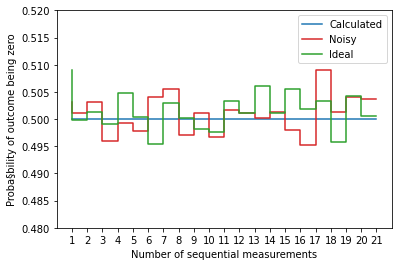

In [145]:
# Graph for results when Lambda=0

x = []

plots = []
ind = (n-1)
for i in range(n,m):
    x.append(ind)

    ind = ind +1
xint = range(min(x), math.ceil(max(x))+1)
    
plt.step(x, zeros_vert_0,color='tab:blue',label="Calculated")
plt.step(x, zeros_n_0,color='tab:red',label="Noisy")
plt.step(x, zeros_i_0,color='tab:green',label="Ideal")

plt.xticks(xint)
plt.ylim([0.480,0.520])
plt.legend()
plt.xlabel('Number of sequential measurements')
plt.ylabel('Proba§bility of outcome being zero')
plt.show()

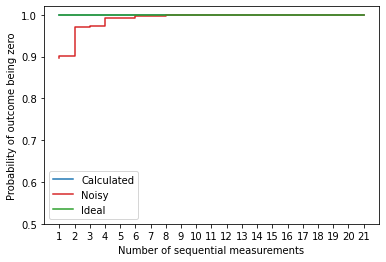

In [146]:
# Graph for results when Lambda=pi/4

x = []

plots = []
ind = (n-1)
for i in range(n,m):
    x.append(ind)

    ind = ind +1
xint = range(min(x), math.ceil(max(x))+1)
    
plt.step(x, zeros_vert_4,color='tab:blue',label="Calculated")
plt.step(x, zeros_n_4,color='tab:red',label="Noisy")
plt.step(x, zeros_i_4,color='tab:green',label="Ideal")

plt.xticks(xint)
plt.ylim([0.5,1.02])
plt.legend()
plt.xlabel('Number of sequential measurements')
plt.ylabel('Probability of outcome being zero')
plt.show()

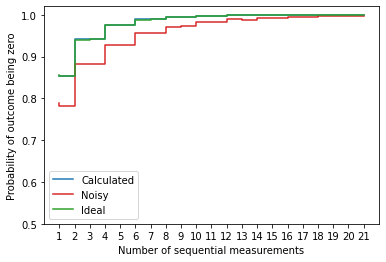

In [147]:
# Graph for results when Lambda=pi/8

x = []

plots = []
ind = (n-1)
for i in range(n,m):
    x.append(ind)

    ind = ind +1
xint = range(min(x), math.ceil(max(x))+1)
    
plt.step(x, zeros_vert_8,color='tab:blue',label="Calculated")
plt.step(x, zeros_n_8,color='tab:red',label="Noisy")
plt.step(x, zeros_i_8,color='tab:green',label="Ideal")


plt.xticks(xint)
plt.ylim([0.5,1.02])
plt.legend()
plt.xlabel('Number of sequential measurements')
plt.ylabel('Probability of outcome being zero')
plt.show()

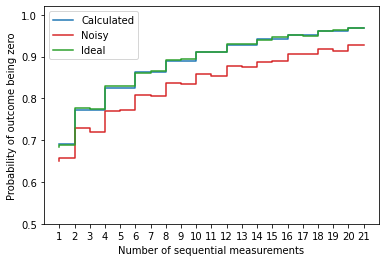

In [148]:
# Graph for results when Lambda=pi/16

x = []

plots = []
ind = (n-1)
for i in range(n,m):
    x.append(ind)

    ind = ind +1
xint = range(min(x), math.ceil(max(x))+1)
    
plt.step(x, zeros_vert_16,color='tab:blue',label="Calculated")
plt.step(x, zeros_n_16,color='tab:red',label="Noisy")
plt.step(x, zeros_i_16,color='tab:green',label="Ideal")

plt.xticks(xint)
plt.ylim([0.5,1.02])
plt.legend()
plt.xlabel('Number of sequential measurements')
plt.ylabel('Probability of outcome being zero')
plt.show()

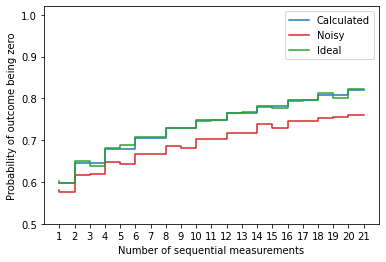

In [149]:
# Graph for results when Lambda=pi/32


x = []

plots = []
ind = (n-1)
for i in range(n,m):
    x.append(ind)

    ind = ind +1

plt.step(x, zeros_vert_32,color='tab:blue',label="Calculated")
plt.step(x, zeros_n_32,color='tab:red',label="Noisy")
plt.step(x, zeros_i_32,color='tab:green',label="Ideal")

plt.xticks(xint)
plt.ylim([0.5,1.02])
plt.legend()
plt.xlabel('Number of sequential measurements')
plt.ylabel('Probability of outcome being zero')
plt.show()

In [61]:
import qiskit
for i in qiskit.__qiskit_version__.items():
    print(i)

('qiskit-terra', '0.17.1')
('qiskit-aer', '0.8.1')
('qiskit-ignis', '0.6.0')
('qiskit-ibmq-provider', '0.12.3')
('qiskit-aqua', '0.9.1')
('qiskit', '0.25.2')
('qiskit-nature', None)
('qiskit-finance', None)
('qiskit-optimization', None)
('qiskit-machine-learning', None)
